## 조건 없는 생성모델(Unconditional Generative Model), GAN

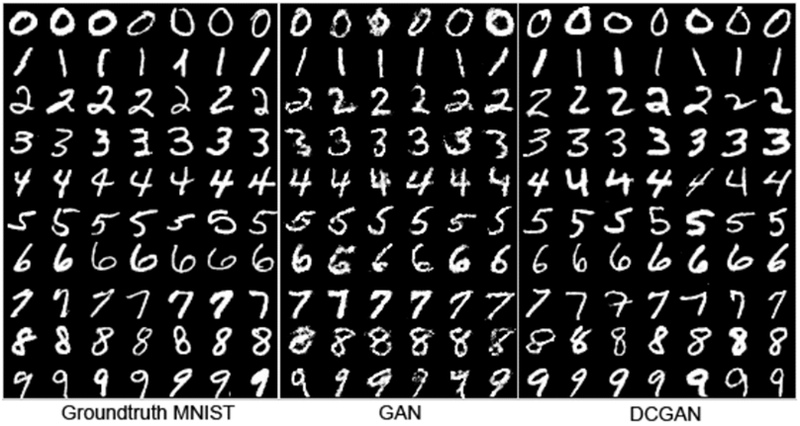  
https://arxiv.org/pdf/1511.06434.pdf

이렇듯 잘 학습된 GAN을 이용해 실제 이미지를 생성할 때 조금 답답한 점이 하나 있다면, 바로 내가 원하는 종류의 이미지를 바로 생성해 내지 못한다는 것입니다.
다시 말해서 일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들었습니다.

우리가 원하는 이미지를 바로바로 생성해 내기 위해서는 어떤 방법을 이용해야 할까요? GAN이라는 생성 모델에 내가 원하는 이미지를 만들기 위한 특정 조건을 줄 수는 없을까요?
기약 없이 "7"이라 쓰인 이미지가 생성되길 기다릴 순 없으니까요.




## 조건 있는 생성모델(Conditional Generative Model), cGAN
onditional Generative Adversarial Nets (cGAN) 은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여,  
내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법이다.

### GAN의 목적 함수
GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전한다.

### cGAN의 목적 함수

### 그림으로 이해하기
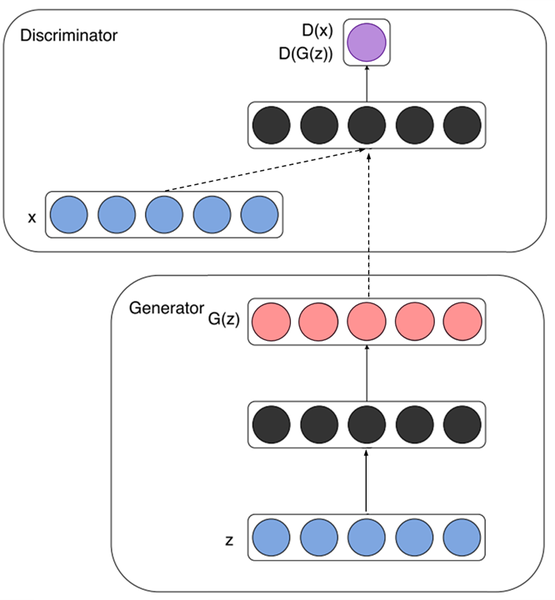

- Generator
노이즈 $z$(파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 $G(z)$ (빨간색)를 생성해낸다.
- Discriminator
실제 데이터 $x$와 Generator가 생성한 가짜 데이터 $G(z)$를 각각 입력받아 $D(x)$ 및 $D(G(z))$ (보라색)를 계산하여 진짜와 가짜를 식별해낸다.
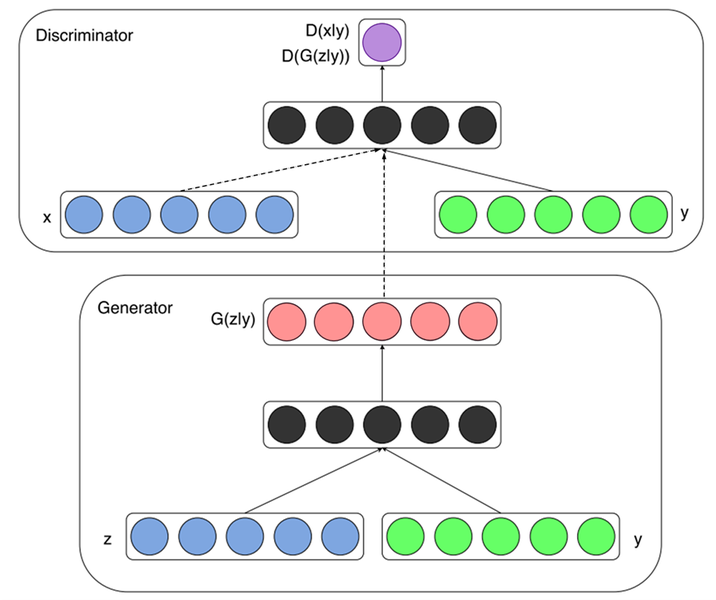

이전 목적함수에서 확인했듯이, cGAN에서 바뀐 부분은 $y$라는 정보가 함께 입력된다는 것이다.
- __Generator__ 노이즈 $z$(파란색)와 추가 정보 $y$(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 $G(z∣y)$를 생성한다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 $y$는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣는다.
- __Discriminator__ 실제 데이터 $x$와 Generator가 생성한 가짜 데이터 $G(z∣y)$를 각각 입력받으며, 마찬가지로 $y$정보가 각각 함께 입력되어 진짜와 가짜를 식별한다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 $x$와 $y$는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 $y$와 Discriminator에 입력되는 $y$는 동일한 레이블을 나타내야 한다.

---
# MNIST

## Generator 구상하기

[TF2-GAN](https://github.com/thisisiron/TF2-GAN)

### 데이터 준비하기

```
$pip list | grep tensorflow-dataset
$pip install tensorflow-dataset
```

tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러오자.

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


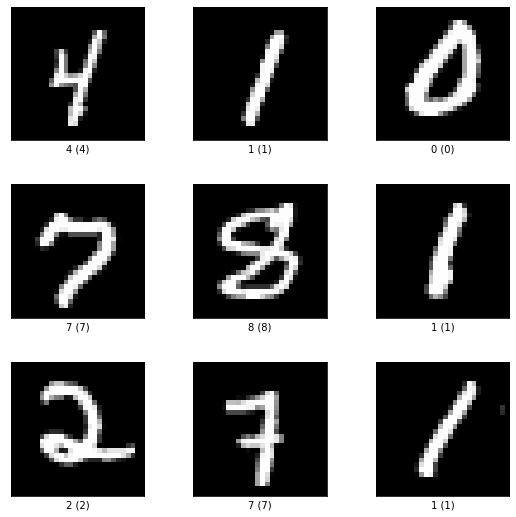

In [2]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

이미지 픽셀 값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 원-핫 인코딩(one-hot encoding)해줬다.  
GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 `gan_preprocessing()`과 `cgan_preprocessing()` 함수를 구성했다.

In [3]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해보자.  
이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 한다.

Label : tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


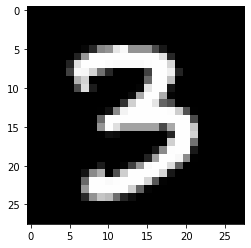

In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

### GAN Generator 구성하기

In [5]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    ## 사용할 모든 레이어를 정의
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        # 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환
        self.reshape = layers.Reshape((28, 28, 1))

    ## forward propagation을 진행
    ## call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과
    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

### cGAN Generator 구성하기

In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

## Discriminator 구성하기

### GAN Discriminator 구성하기
실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해보자.

In [7]:
class DiscriminatorGAN(Model):
    ## __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓는다.
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        
        # Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        # fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        
        # 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력
        return x

### cGAN Discriminator 구성하기
cGAN의 Discriminator는 `Maxout`이라는 특별한 레이어가 사용된다.
`Maxout`은 두 레이어 사이를 연결할 때,   
여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져온다.

식으로 표현하면 아래와 같다.  
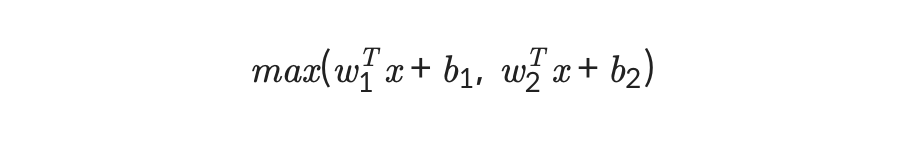

참고링크는 아래와 같다
- [[라온피플] Stochastic Pooling & Maxout](https://m.blog.naver.com/PostView.nhn?blogId=laonple&logNo=221259325819&proxyReferer=&proxyReferer=https:%2F%2Fwww.google.com%2F)
- [[Paper] Maxout Networks](https://arxiv.org/pdf/1302.4389.pdf)

In [8]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        # units 차원 수를 가진 fully-connected 레이어를 
        # pieces개 만큼 만들고 그 중 최대 값을 출력
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
        # units=100, pieces=10으로 설정 된다면 입력으로 부터 
        # 100차원의 representation을 10개 만들고, 
        # 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)


`Maxout` 레이어를 3번만 사용한 cGAN의 Discriminato의 구성은 아래와 같다.

In [9]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

## 학습 및 테스트하기
Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해보자.

우선은 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의하자.  
진짜 및 가짜를 구별하기 위해 `Binary Cross Entropy`를 사용하고,  
`Adam optimizer`를 이용해 학습한다.

In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

### GAN으로 MNIST 학습하기
이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용하자.  
하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 생성했다.

In [11]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    # 입력으로 사용되는 노이즈를 100차원으로 설정
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [12]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)
        
        # 100번의 반복마다 각 손실(loss)을 출력
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.108146905899048, D:0.14359085261821747
[1/10 EPOCHS, 200 ITER] G:2.312129020690918, D:0.11937233060598373
[1/10 EPOCHS, 300 ITER] G:2.2388505935668945, D:0.16565075516700745
[1/10 EPOCHS, 400 ITER] G:2.8592395782470703, D:0.1202683076262474
[2/10 EPOCHS, 100 ITER] G:4.573461055755615, D:0.0761713981628418
[2/10 EPOCHS, 200 ITER] G:3.2857425212860107, D:0.22519932687282562
[2/10 EPOCHS, 300 ITER] G:2.669771432876587, D:0.22401481866836548
[2/10 EPOCHS, 400 ITER] G:2.333777666091919, D:0.27772748470306396
[3/10 EPOCHS, 100 ITER] G:3.8894362449645996, D:0.11495295912027359
[3/10 EPOCHS, 200 ITER] G:3.019561767578125, D:0.11102495342493057
[3/10 EPOCHS, 300 ITER] G:3.4833998680114746, D:0.05963173508644104
[3/10 EPOCHS, 400 ITER] G:2.232351064682007, D:0.30001604557037354
[4/10 EPOCHS, 100 ITER] G:3.7733330726623535, D:0.19073531031608582
[4/10 EPOCHS, 200 ITER] G:3.9621505737304688, D:0.05566508322954178
[4/10 EPOCHS, 300 ITER] G:2.909238338470459, D:0.14569863

100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화해보자.

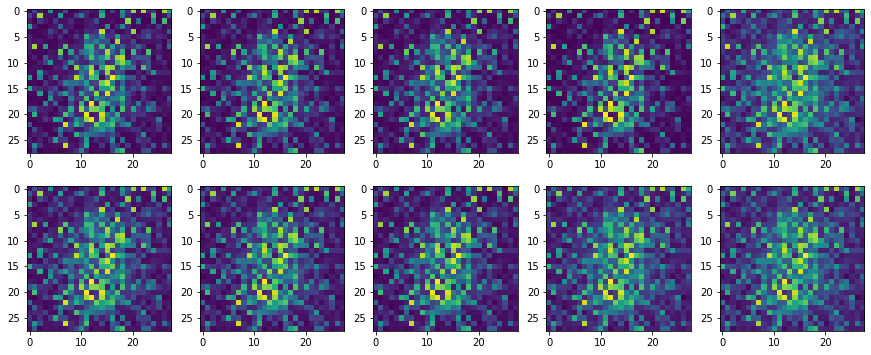

In [13]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

10 epoch의 학습만으로는 좋은 결과를 기대할 수 없으니    
위 구현을 그대로 이용하여 500 epoch 학습한 가중치를   
아래에 첨부한 .zip을 다운받아 작업환경을 구성하자.  
[GAN_500.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/GAN_500.zip)

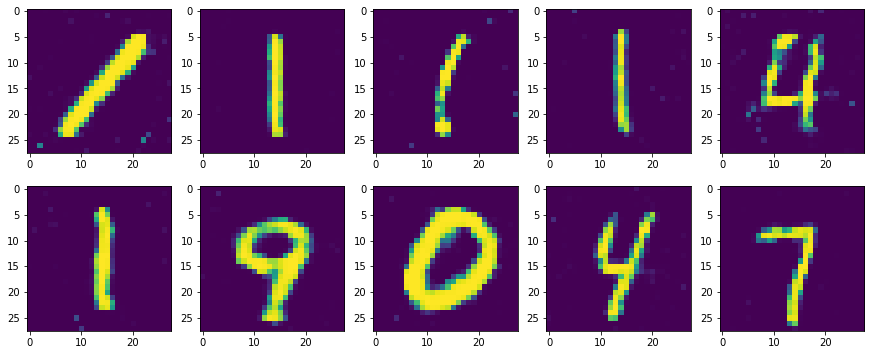

In [14]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기
이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용하여 연습 삼아 1 epoch만 학습 시켜보자.

In [15]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:2.995398998260498, D:0.06948156654834747
[1/1 EPOCHS, 199 ITER] G:3.525587797164917, D:0.051824793219566345
[1/1 EPOCHS, 299 ITER] G:4.375889301300049, D:0.028517238795757294
[1/1 EPOCHS, 399 ITER] G:5.37429141998291, D:0.040613893419504166


1epoch만으로는 부족하니 첨부된 파일(CGAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성하자.  
[CGAN_500.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/CGAN_500.zip)

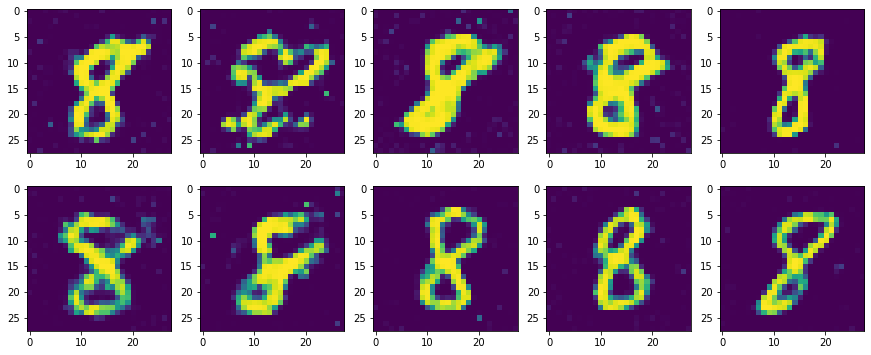

In [17]:
number =  8

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

---
# 자... 색 들어간다!

## 데이터 준비하기
pix2pix 모델에 대해서 직접 구현하고 실험해보자.
사용해볼 데이터셋은 __Sketch2Pokemon__ 이라는 데이터셋이다. 

- [Sketch2Pokemon info](https://www.kaggle.com/norod78/sketch2pokemon)
- [sketch2pokemon.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/sketch2pokemon.zip)

학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다.

In [18]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


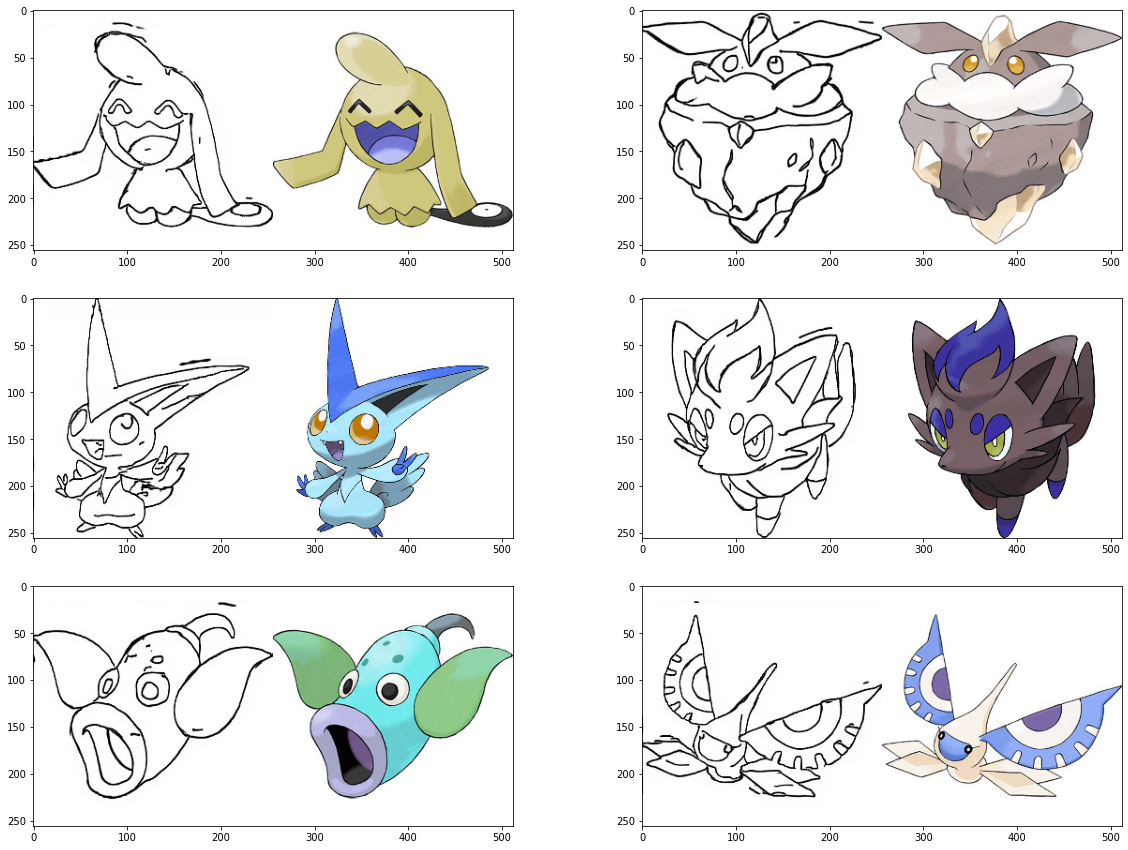

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [20]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하자.

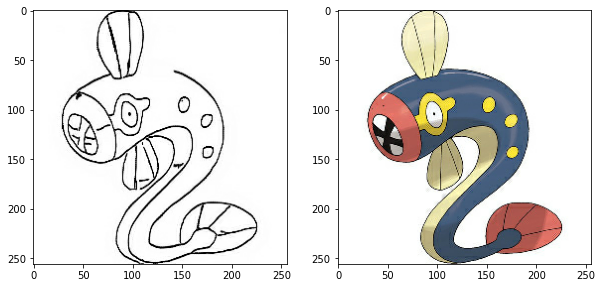

In [21]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

학습에 사용할 수 있는 데이터의 수는 약 800개뿐입니다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용한다.

In [22]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

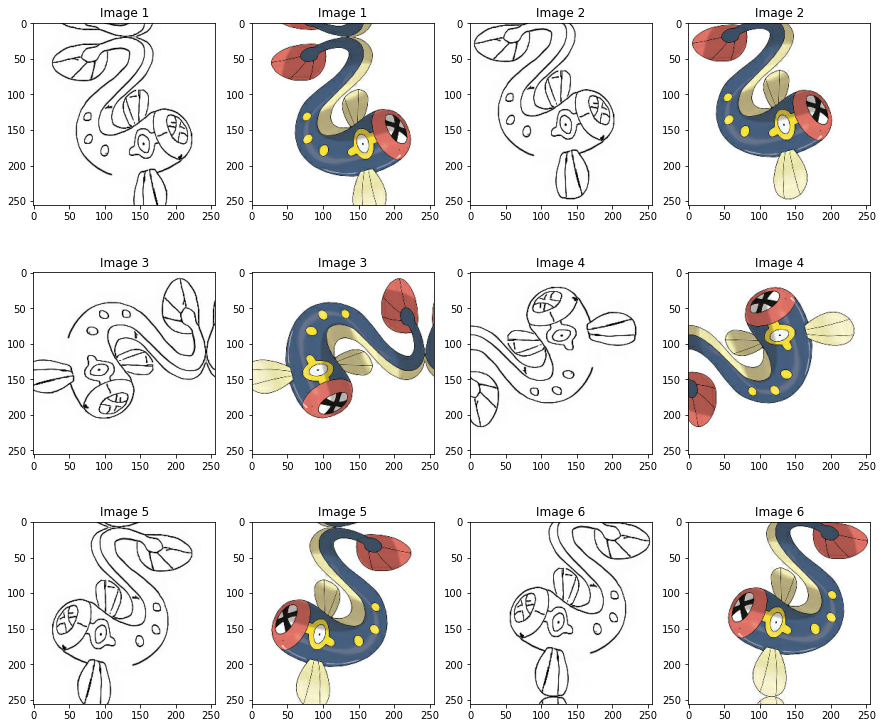

In [23]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해보자.

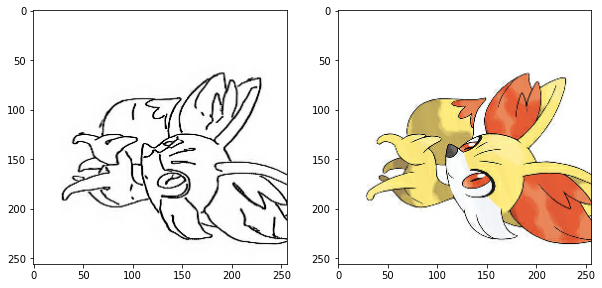

In [24]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Generator 구성하기
pix2pix 논문에서 Generator를 구성하는데 필요한 정보는 아래 이미지와 같다.   
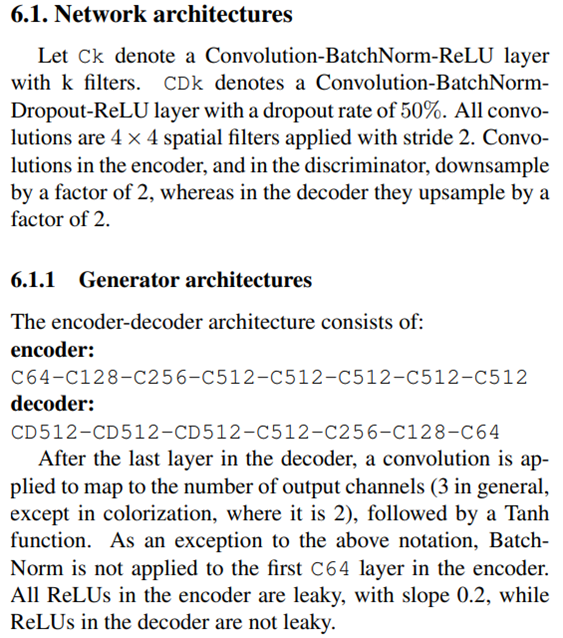

### Generator 구현하기
위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이   
"Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을   
아래와 같이 하나의 레이어로 만들었다.

In [25]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    ## __init__() 메서드에서 n_filters, use_bn를 설정하여 
    ## 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있다.
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [26]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

각 블록을 거치면서 사용할 필터의 개수를 `filters`라는 리스트에 지정해 두었으며, `blocks`이라는 리스트에는 사용할 블록들을 정의해 넣어두고, `call()` 메서드에서 차례대로 블록들을 통과한다.

구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자.


In [27]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고,   
사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 출력됨을 확인할 수 있다.

In [28]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

(1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해보자.

In [29]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 출력됨을 확인할 수 있다.

`tf.keras.Model`을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해보자.

In [30]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## Generator 재구성하기
Pix2Pix의 Generator 구조는 두 가지를 제안했다.
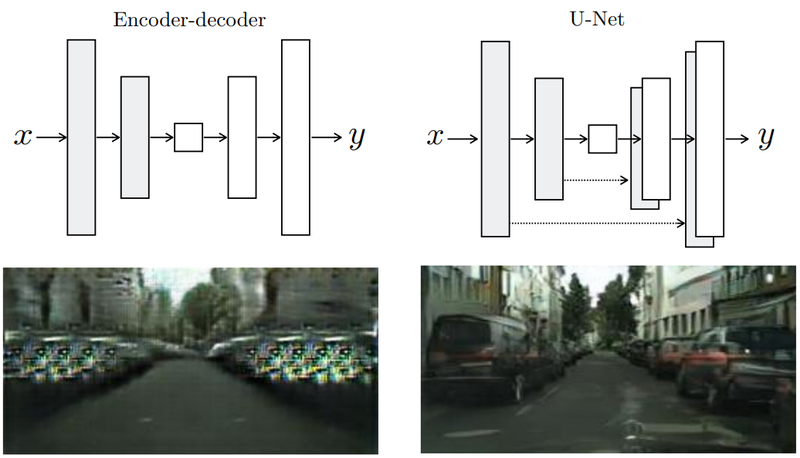  

이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조이다.  
더 좋은 결과를 위해서 이전의 구현했던 것들을 수정하여 위 그름의 U-Net구조를 만들어보고 사용해보자.

In [31]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

U-Net Generator를 정의해보자.

In [32]:
class UNetGenerator(Model):
    ## __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    ## call()에서 forward propagation
    def call(self, x):
        # skip connection을 위해 features 라는 리스트를 만들고 
        features = []
        # Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [33]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## Discriminator 구성하기
Discriminator를 만들어 Pix2Pix 구조를 완성시켜보자.

Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보는 아래와 같다.
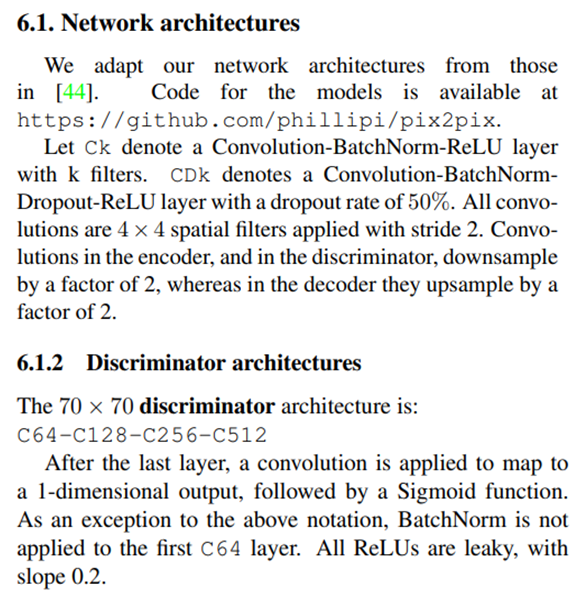

### Discriminator 구현하기

In [46]:
class DiscBlock(layers.Layer):
    ## 필터의 수(n_filters), 
    ## 필터가 순회하는 간격(stride), 
    ## 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), 
    ## BatchNorm의 사용 여부(use_bn), 
    ## 활성화 함수 사용 여부(act)
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [47]:
inputs = Input((128,128,32))
# layers.ZeroPadding2D()를 통과하면, 
# width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어남.
# 출력 : (130,130,32)
out = layers.ZeroPadding2D()(inputs)
# 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 
# width 및 height 가 3씩 줄어듬.
# OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1
# 출력 : (127,127,64)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
# 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않음
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_62 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [48]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [49]:
Discriminator().get_summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 256, 256, 6)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_14[0][0]       

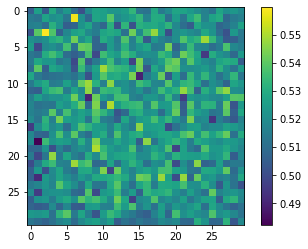

In [50]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 학습 및 테스트하기

In [51]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

사용할 optimizer는 논문과 동일하게 설정

In [52]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [53]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [54]:
EPOCHS = 10 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0145                     
L1_loss:0.5522                     
Discriminator_loss:1.1704

EPOCH[1] - STEP[20]                     
Generator_loss:1.0443                     
L1_loss:0.3587                     
Discriminator_loss:1.3974

EPOCH[1] - STEP[30]                     
Generator_loss:0.8702                     
L1_loss:0.3019                     
Discriminator_loss:1.2239

EPOCH[1] - STEP[40]                     
Generator_loss:1.0258                     
L1_loss:0.2797                     
Discriminator_loss:1.0188

EPOCH[1] - STEP[50]                     
Generator_loss:1.4308                     
L1_loss:0.2346                     
Discriminator_loss:0.6871

EPOCH[1] - STEP[60]                     
Generator_loss:2.0012                     
L1_loss:0.3418                     
Discriminator_loss:0.8280

EPOCH[1] - STEP[70]                     
Generator_loss:1.8977                     
L1_loss:0.2679                    

채색해보자.

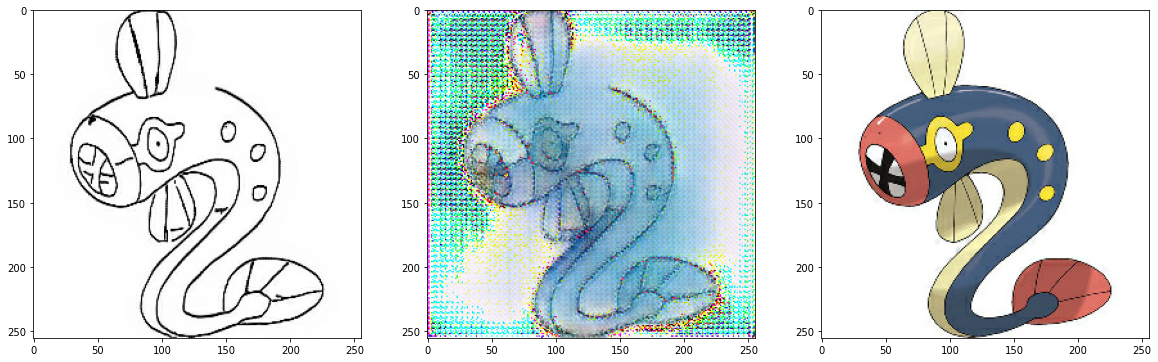

In [55]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))